# Geo

1. Plot sample distribution on world map.
1. Plot timeline by study.

---
## Setup

### Import Modules

In [1]:
import geopandas
import matplotlib.pyplot as plt
from matplotlib import gridspec, colors
import os
import shapely
import treetime
from Bio import Phylo
import math
import seaborn as sns
import contextily as ctx

### File Paths

In [2]:
# Remember metadata is useful because it's just the tips, no internal nodes, for parse dates
metadata_path = "../../docs/results/latest/metadata/metadata.tsv"
outdir = "../../docs/results/latest/geo"
tree_path = "../../docs/results/latest/parse_tree/parse_tree.xml"
#tree_df_path = "../../docs/results/latest/parse_tree/parse_tree.tsv"
tree_df_path = "../../docs/results/latest/mugration/mugration.tsv"
# Create output directory if it doesn't exist
if not os.path.exists(outdir):
    os.mkdir(outdir)

### Variables

In [3]:
from config import *

GEO_ATTR = "Province"
NAME_COL = "Sample"
DATE_COL = "Date"

SCRIPT_NAME = "geo"

DISC_CMAPLIST = ["#FC4E07","#00AFBB", "grey"]

#pd.set_option("display.max_rows", 10, "display.max_columns", None)

### Read input tree and dataframe

In [4]:
tree = Phylo.read(tree_path, "phyloxml")
tree.ladderize(reverse=False)

tree_df = pd.read_csv(tree_df_path, sep='\t')
# Fix the problem with multiple forms of NA in the table
# Consolidate missing data to the NO_DATA_CHAR
tree_df.fillna(NO_DATA_CHAR, inplace=True)
tree_df.set_index("Name", inplace=True)

tree_df

,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number,Mugration_Branch_Number,Mugration_Branch_Number_Confidence,Mugration_Branch_Major,Mugration_Branch_Major_Confidence
Name,,,,,,,,,,,,,,,,,,,,,,,,,
NODE0,100,100,0.000000e+00,red,0.000000,17.855175,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,3.0,0.255570,0.PRE,0.998937
SAMEA3541827,NA,NA,3.850300e-06,grey,0.000004,1.000000,RISE509,[-2876:-2677],[-4897:-4698],Russia,Krasnoyarsk Krai,64.6863,97.7453,63.3234,97.098,Bronze Age,0.PRE,0.PRE2,SAMEA3541827,KEEP: SRA Ancient,0,3.0,0.255668,0.PRE,1.000000
NODE2,100,100,1.327050e-05,red,0.000013,3.156250,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,3.0,0.255668,0.PRE,0.999999
SAMEA104233046,NA,NA,2.248300e-06,grey,0.000016,2.000000,Gyvakarai1,[-2621:-2472],[-4642:-4493],Lithuania,Panevezys County,55.35,23.75,55.9156,25.0312,Bronze Age,0.PRE,0.PRE1,SAMEA104233046,KEEP: SRA Ancient,0,3.0,0.255766,0.PRE,1.000000
NODE4,90.2,100,1.363600e-05,black,0.000027,4.312500,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,3.0,0.255766,0.PRE,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCA_000268965.1_ASM26896v1_genomic,NA,NA,4.692000e-07,grey,0.000077,631.000000,PY-65,2010,-11,Peru,La Libertad,-6.86997,-75.0459,-8,-78.5,Orientalis,1.ORI,1.ORI1,SAMN02141486,KEEP: Assembly Modern,1,1.0,1.000000,1.ORI,1.000000
GCA_000269425.1_ASM26942v1_genomic,NA,NA,2.350000e-08,grey,0.000077,632.000000,PY-94,2010,-11,Peru,Cajamarca,-6.86997,-75.0459,-6.25,-78.8333,Orientalis,1.ORI,1.ORI1,SAMN02141497,KEEP: Assembly Modern,1,1.0,1.000000,1.ORI,1.000000
NODE1263,0,97,2.346000e-07,black,0.000077,633.500000,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.0,1.000000,1.ORI,1.000000


### Import Dataframe as Pandas

In [5]:
metadata_df = pd.read_csv(metadata_path, sep='\t')
# Fix the problem with multiple forms of NA in the table
# Consolidate missing data to the NO_DATA_CHAR
metadata_df.fillna(NO_DATA_CHAR, inplace=True)
metadata_df.set_index("Sample", inplace=True)

### Parse Dates

In [6]:
dates_dict = treetime.utils.parse_dates(metadata_path, 
                                   date_col=DATE_COL, 
                                   name_col = NAME_COL)


Attempting to parse dates...
	Using column 'Sample' as name. This needs match the taxon names in the tree!!
	Using column 'Date' as date.


### Convert Dataframe to GeoPandas

In [7]:
# For samples with no province info, set to country
for rec in metadata_df.iterrows():
    sample = rec[0]
    data = rec[1]
    province = data["Province"]
    if province == NO_DATA_CHAR:
        # Try to set latlon to country
        country = data["Country"]
        if country != NO_DATA_CHAR:
            metadata_df.at[sample, "Province"] = data["Country"]
            metadata_df.at[sample, "ProvinceLat"] = data["CountryLat"]
            metadata_df.at[sample, "ProvinceLon"] = data["CountryLon"]
            

In [8]:
# Remove missing data
df = metadata_df[metadata_df[GEO_ATTR + "Lon"] != NO_DATA_CHAR]

geometry = [shapely.geometry.Point(xy) for xy in zip(df[GEO_ATTR + "Lon"], df[GEO_ATTR + "Lat"])]
#df = df.drop([GEO_ATTR + "Lon", GEO_ATTR + "Lat"], axis=1)
#WGS84 = "epsg:4326"
gdf_points = geopandas.GeoDataFrame(df, crs=CRS, geometry=geometry)

gdf_points

,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number,geometry
Sample,,,,,,,,,,,,,,,,
GCA_009909635.1_ASM990963v1_genomic,9_10,1923,-98,Russia,Rostov Oblast,64.6863,97.7453,47.6222,40.7958,Medievalis,2.MED,2.MED1,SAMN13632815,KEEP: Assembly Modern,2,POINT (40.79579 47.62225)
GCA_009669545.1_ASM966954v1_genomic,42126,2006,-15,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722925,KEEP: Assembly Modern,0,POINT (85.46335 42.48050)
GCA_009669555.1_ASM966955v1_genomic,42123,2005,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722924,KEEP: Assembly Modern,0,POINT (85.46335 42.48050)
GCA_009669565.1_ASM966956v1_genomic,42118,2005,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722923,KEEP: Assembly Modern,0,POINT (85.46335 42.48050)
GCA_009669605.1_ASM966960v1_genomic,42117,2005,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722922,KEEP: Assembly Modern,0,POINT (85.46335 42.48050)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IP542,IP542,1952,-69,Kenya,Kenya,1.44197,38.4314,1.44197,38.4314,Antiqua,1.ANT,1.ANT1,IP542,KEEP: Local Modern,1,POINT (38.43140 1.44197)
IP543,IP543,1953,-68,Democratic Republic of the Congo,Democratic Republic of the Congo,-2.98143,23.8223,-2.98143,23.8223,Antiqua,1.ANT,1.ANT1,IP543,KEEP: Local Modern,1,POINT (23.82226 -2.98143)
IP557,IP557,1963,-58,Iran,Kurdistan,32.6475,54.5644,35.6728,47.0124,Medievalis,2.MED,2.MED1,IP557,KEEP: Local Modern,2,POINT (47.01244 35.67280)


### Prep Plotting Data

In [23]:
# --------------------------------------
# World Basemap
world_polygons = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# Data selection
# --------------------------------------
# Keller et al. 2019
gdf_keller = gdf_points[(
    gdf_points["BioSampleComment"].str.contains("Keller 2019")) 
    & (gdf_points["BioSampleComment"].str.contains("Modern"))]
df_keller = tree_df[
    (tree_df["BioSampleComment"].str.contains("Keller 2019")) 
    & (tree_df["BioSampleComment"].str.contains("Modern"))]
# --------------------------------------
# This Study
gdf_this_study = gdf_points[(gdf_points["BioSampleComment"].str.contains("Modern"))]
df_this_study = tree_df[(tree_df["BioSampleComment"].str.contains("Modern"))]

gdf_ancient = gdf_points[gdf_points["BioSampleComment"].str.contains("Ancient")]
df_ancient = tree_df[tree_df["BioSampleComment"].str.contains("Ancient")]

plot_dict = {"Ancient DNA" : {
                  "gdf" : gdf_ancient,
                  "df" : df_ancient,    
                  "geo_count" : {},
                  "geo_size" : [],
                  "date_count" : {}, 
                  "date_list" : [], 
                  "label" : "Ancient DNA",
              },  
              "This Study" : {
                  "gdf" : gdf_this_study,  
                  "df" : df_this_study,                   
                  "geo_count" : {},
                  "geo_size" : [],
                  "date_count" : {},   
                  "date_list" : [],  
                  "label" : "This Study",                  
              },              
             "Keller et al. 2019" : {
                  "gdf" : gdf_keller,             
                  "df" : df_keller,                  
                  "geo_count" : {},
                  "geo_size" : [],
                  "date_count" : {},   
                  "date_list" : [],  
                  "label" : "Keller et al. (2019)",                     
              },           
             }

tree_df["Study_Color"] = ["black" for row in range(0,len(tree_df))]  

layer = 0
for dataset in plot_dict:
    # Iterate through records for each dataset
    layer += 1
    
    df = plot_dict[dataset]["df"]
    gdf = plot_dict[dataset]["gdf"]
    
    # Add the study color to the dataframe
    for c in tree.find_clades():
        # Skip internal nodes
        if not c.is_terminal(): continue
        # If node is in the datafame and hasn't been recolored
        # Note, later datasets in dict overwrite earlier
        if c.name in df.index:
            #color = colors.rgb2hex(DISC_CMAP(layer-1))
            color = DISC_CMAPLIST[layer-1]
            tree_df.at[c.name, "Study_Color"] = color
            
    for rec in gdf.iterrows():
        sample = rec[0]
        date = dates_dict[sample]
        geo = rec[1][GEO_ATTR]

        # Convert date to float and get mean if range
        if type(date) == list:
            date = sum(dates_dict[sample]) / 2
        date = float(date)     
        plot_dict[dataset]["date_list"].append(date)
        
        if date not in plot_dict[dataset]["date_count"]:
            plot_dict[dataset]["date_count"][date] = 0
        plot_dict[dataset]["date_count"][date] += 1   
        
        # Add geo info
        if geo not in plot_dict[dataset]["geo_count"]:
            plot_dict[dataset]["geo_count"][geo] = 0
        plot_dict[dataset]["geo_count"][geo] += 1   
        
    # Drop duplicate entries for geo plotting
    gdf = gdf.drop_duplicates(subset = GEO_ATTR, keep = 'first')
    for geo in gdf[GEO_ATTR]:
        size = plot_dict[dataset]["geo_count"][geo]
        plot_dict[dataset]["geo_size"].append(size)
        
    plot_dict[dataset]["gdf"] = gdf

# Show dataframe 
tree_df

,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number,Mugration_Branch_Number,Mugration_Branch_Number_Confidence,Mugration_Branch_Major,Mugration_Branch_Major_Confidence,Study_Color
Name,,,,,,,,,,,,,,,,,,,,,,,,,,
NODE0,100,100,0.000000e+00,red,0.000000,17.855175,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,3.0,0.255570,0.PRE,0.998937,black
SAMEA3541827,NA,NA,3.850300e-06,grey,0.000004,1.000000,RISE509,[-2876:-2677],[-4897:-4698],Russia,Krasnoyarsk Krai,64.6863,97.7453,63.3234,97.098,Bronze Age,0.PRE,0.PRE2,SAMEA3541827,KEEP: SRA Ancient,0,3.0,0.255668,0.PRE,1.000000,#FC4E07
NODE2,100,100,1.327050e-05,red,0.000013,3.156250,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,3.0,0.255668,0.PRE,0.999999,black
SAMEA104233046,NA,NA,2.248300e-06,grey,0.000016,2.000000,Gyvakarai1,[-2621:-2472],[-4642:-4493],Lithuania,Panevezys County,55.35,23.75,55.9156,25.0312,Bronze Age,0.PRE,0.PRE1,SAMEA104233046,KEEP: SRA Ancient,0,3.0,0.255766,0.PRE,1.000000,#FC4E07
NODE4,90.2,100,1.363600e-05,black,0.000027,4.312500,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,3.0,0.255766,0.PRE,1.000000,black
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCA_000268965.1_ASM26896v1_genomic,NA,NA,4.692000e-07,grey,0.000077,631.000000,PY-65,2010,-11,Peru,La Libertad,-6.86997,-75.0459,-8,-78.5,Orientalis,1.ORI,1.ORI1,SAMN02141486,KEEP: Assembly Modern,1,1.0,1.000000,1.ORI,1.000000,#00AFBB
GCA_000269425.1_ASM26942v1_genomic,NA,NA,2.350000e-08,grey,0.000077,632.000000,PY-94,2010,-11,Peru,Cajamarca,-6.86997,-75.0459,-6.25,-78.8333,Orientalis,1.ORI,1.ORI1,SAMN02141497,KEEP: Assembly Modern,1,1.0,1.000000,1.ORI,1.000000,#00AFBB
NODE1263,0,97,2.346000e-07,black,0.000077,633.500000,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.0,1.000000,1.ORI,1.000000,black


### Plot

Swarm Plot Alternative

In [10]:
"""fig = plt.figure(figsize=figsize, dpi=dpi)
# Map axis
ax0 = fig.add_axes([0, -0.9, 1, 1.75])
ax1 = fig.add_axes([0, 0, 1, 1])
# Timeline axes
ax2 = fig.add_axes([0.05, 0.1, 0.9, 0.15])
ax3 = fig.add_axes([0.05, -0.075, 0.9, 0.20])
ax4 = fig.add_axes([0.05, -0.225, 0.9, 0.10])
# Tree axis
ax5 = fig.add_axes([0.05, -0.8, 0.9, 0.5])

# Make everything appear larger
marker_scale = 4

# --------------------------------------
# World Basemap
world_polygons.plot(ax=ax1, 
                    zorder=1, 
                    alpha=0.5, 
                    color="grey",
                    edgecolor="white", 
                    linewidth=0.25,
                   )

layer = 0
for dataset in plot_dict.keys():
    gdf = plot_dict[dataset]["gdf"]
    layer += 1
    
    # Plot map
    geo_size = plot_dict[dataset]["geo_size"]
    gdf.plot(ax=ax1, 
             zorder=layer, 
             markersize=[s*marker_scale for s in geo_size],
             color=DISC_CMAPLIST[layer-1],
             edgecolor="black",
             linewidths=0.5,
             label=plot_dict[dataset]["label"],
             legend=True,
             alpha=1,
             )

# Plot timeline
sns.swarmplot(x=plot_dict["Ancient DNA"]["date_list"], ax=ax4, size=2, color=DISC_CMAPLIST[0]) 
sns.swarmplot(x=plot_dict["This Study"]["date_list"], ax=ax3, size=2, color=DISC_CMAPLIST[1])
sns.swarmplot(x=plot_dict["Keller et al. 2019"]["date_list"], ax=ax2, size=2, color=DISC_CMAPLIST[2])


# Plot tree     
Phylo.draw(tree,
           axes=ax5,
           show_confidence=False, 
           label_func = lambda x:'', 
           do_show=False,
          )

tip_data = tree_df[(tree_df["Branch_Support_Color"] == TERM_COL)]
ax5.scatter(data=tip_data, 
            x="coord_x", 
            y="coord_y", 
            s=10, 
            c="Study_Color", 
            edgecolor="black", 
            linewidth=0.1, 
            zorder=2)

# --------------------------------------
# Limits

# Sorry Antarctica
ax1.set_ylim(-63,)

ax2.set_xlim(1900,2020)
ax3.set_xlim(1900,2020)
#ax2.set_ylim(1.5,3.5)

ax4.set_xlim(-3000,2000)

x_buffer = max(tree_df["coord_x"]) * 0.05
y_buffer = math.ceil(len(tree.get_terminals()) * 0.05)

ax5.set_xlim(0 - x_buffer, max(tree_df["coord_x"]) + x_buffer)
ax5.set_ylim(len(tree.get_terminals()) + y_buffer, 0 - y_buffer)

# --------------------------------------
# Labels

ax0.set_xticks([])
ax0.set_yticks([])

ax1.set_title("Distribution of " 
          + "$\it Yersinia$" 
          + " " 
          + "$\it pestis$"
          + " " 
          + "genomes")
ax1.axis('off')

ax2.axis('off')

ax3.set_xticks([x for x in range(1900,2021,10)])
ax3.set_yticks([])

ax4.set_xticks([x for x in range(-3000,1901,500)] + [1900])
ax4.set_yticks([])

ax4.set_xlabel("Collection Date")

ax5.set_xlabel("Branch Length")
ax5.set_ylabel("")
ax5.set_yticks([])
# --------------------------------------
# Layout

ax0.axhline(linewidth=1, color='black', y=0.65)

ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(True)
ax3.spines['left'].set_visible(False)

ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['bottom'].set_visible(True)
ax4.spines['left'].set_visible(False)

ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.spines['bottom'].set_visible(True)
ax5.spines['left'].set_visible(False)
# --------------------------------------
# Legend

color_legend = ax1.legend(loc="center left",
                          bbox_to_anchor=(0.01, 0.4),
                          ncol=1,
                          borderpad = 1.5, 
                          title="Study", 
                          title_fontsize=6,
                          fontsize=6, 
                          frameon=True,
                         )
for handle in color_legend.legendHandles:
    handle.set_sizes([20])


size_l1  = plt.scatter([],[], s=1 * marker_scale, edgecolors='black', color="white")
size_l10 = plt.scatter([],[], s=10 * marker_scale, edgecolors='black', color="white")
size_l100 = plt.scatter([],[], s=100 * marker_scale, edgecolors='black', color="white")

size_labels = ["1", "10", "100"]

size_legend = plt.legend([size_l1, size_l10, size_l100], 
                 size_labels,
                 loc="upper left", 
                 bbox_to_anchor=(-0.045, 2.33),
                 ncol=3,
                 borderpad = 1.8, 
                 title="Sample Size", 
                 title_fontsize=6,
                 fontsize=6, 
                 frameon=True,
                 #labelspacing=2,
                 handletextpad=1,
                )
 
# Add multiple legends as artists
#ax1.add_artist(color_legend)
#ax1.add_artist(size_legend)


# --------------------------------------------
# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_map_timeline_swarm." + FMT)
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")
"""

'fig = plt.figure(figsize=figsize, dpi=dpi)\n# Map axis\nax0 = fig.add_axes([0, -0.9, 1, 1.75])\nax1 = fig.add_axes([0, 0, 1, 1])\n# Timeline axes\nax2 = fig.add_axes([0.05, 0.1, 0.9, 0.15])\nax3 = fig.add_axes([0.05, -0.075, 0.9, 0.20])\nax4 = fig.add_axes([0.05, -0.225, 0.9, 0.10])\n# Tree axis\nax5 = fig.add_axes([0.05, -0.8, 0.9, 0.5])\n\n# Make everything appear larger\nmarker_scale = 4\n\n# --------------------------------------\n# World Basemap\nworld_polygons.plot(ax=ax1, \n                    zorder=1, \n                    alpha=0.5, \n                    color="grey",\n                    edgecolor="white", \n                    linewidth=0.25,\n                   )\n\nlayer = 0\nfor dataset in plot_dict.keys():\n    gdf = plot_dict[dataset]["gdf"]\n    layer += 1\n    \n    # Plot map\n    geo_size = plot_dict[dataset]["geo_size"]\n    gdf.plot(ax=ax1, \n             zorder=layer, \n             markersize=[s*marker_scale for s in geo_size],\n             color=DISC_CMAPLIS

---
# Modular Plots

## Map

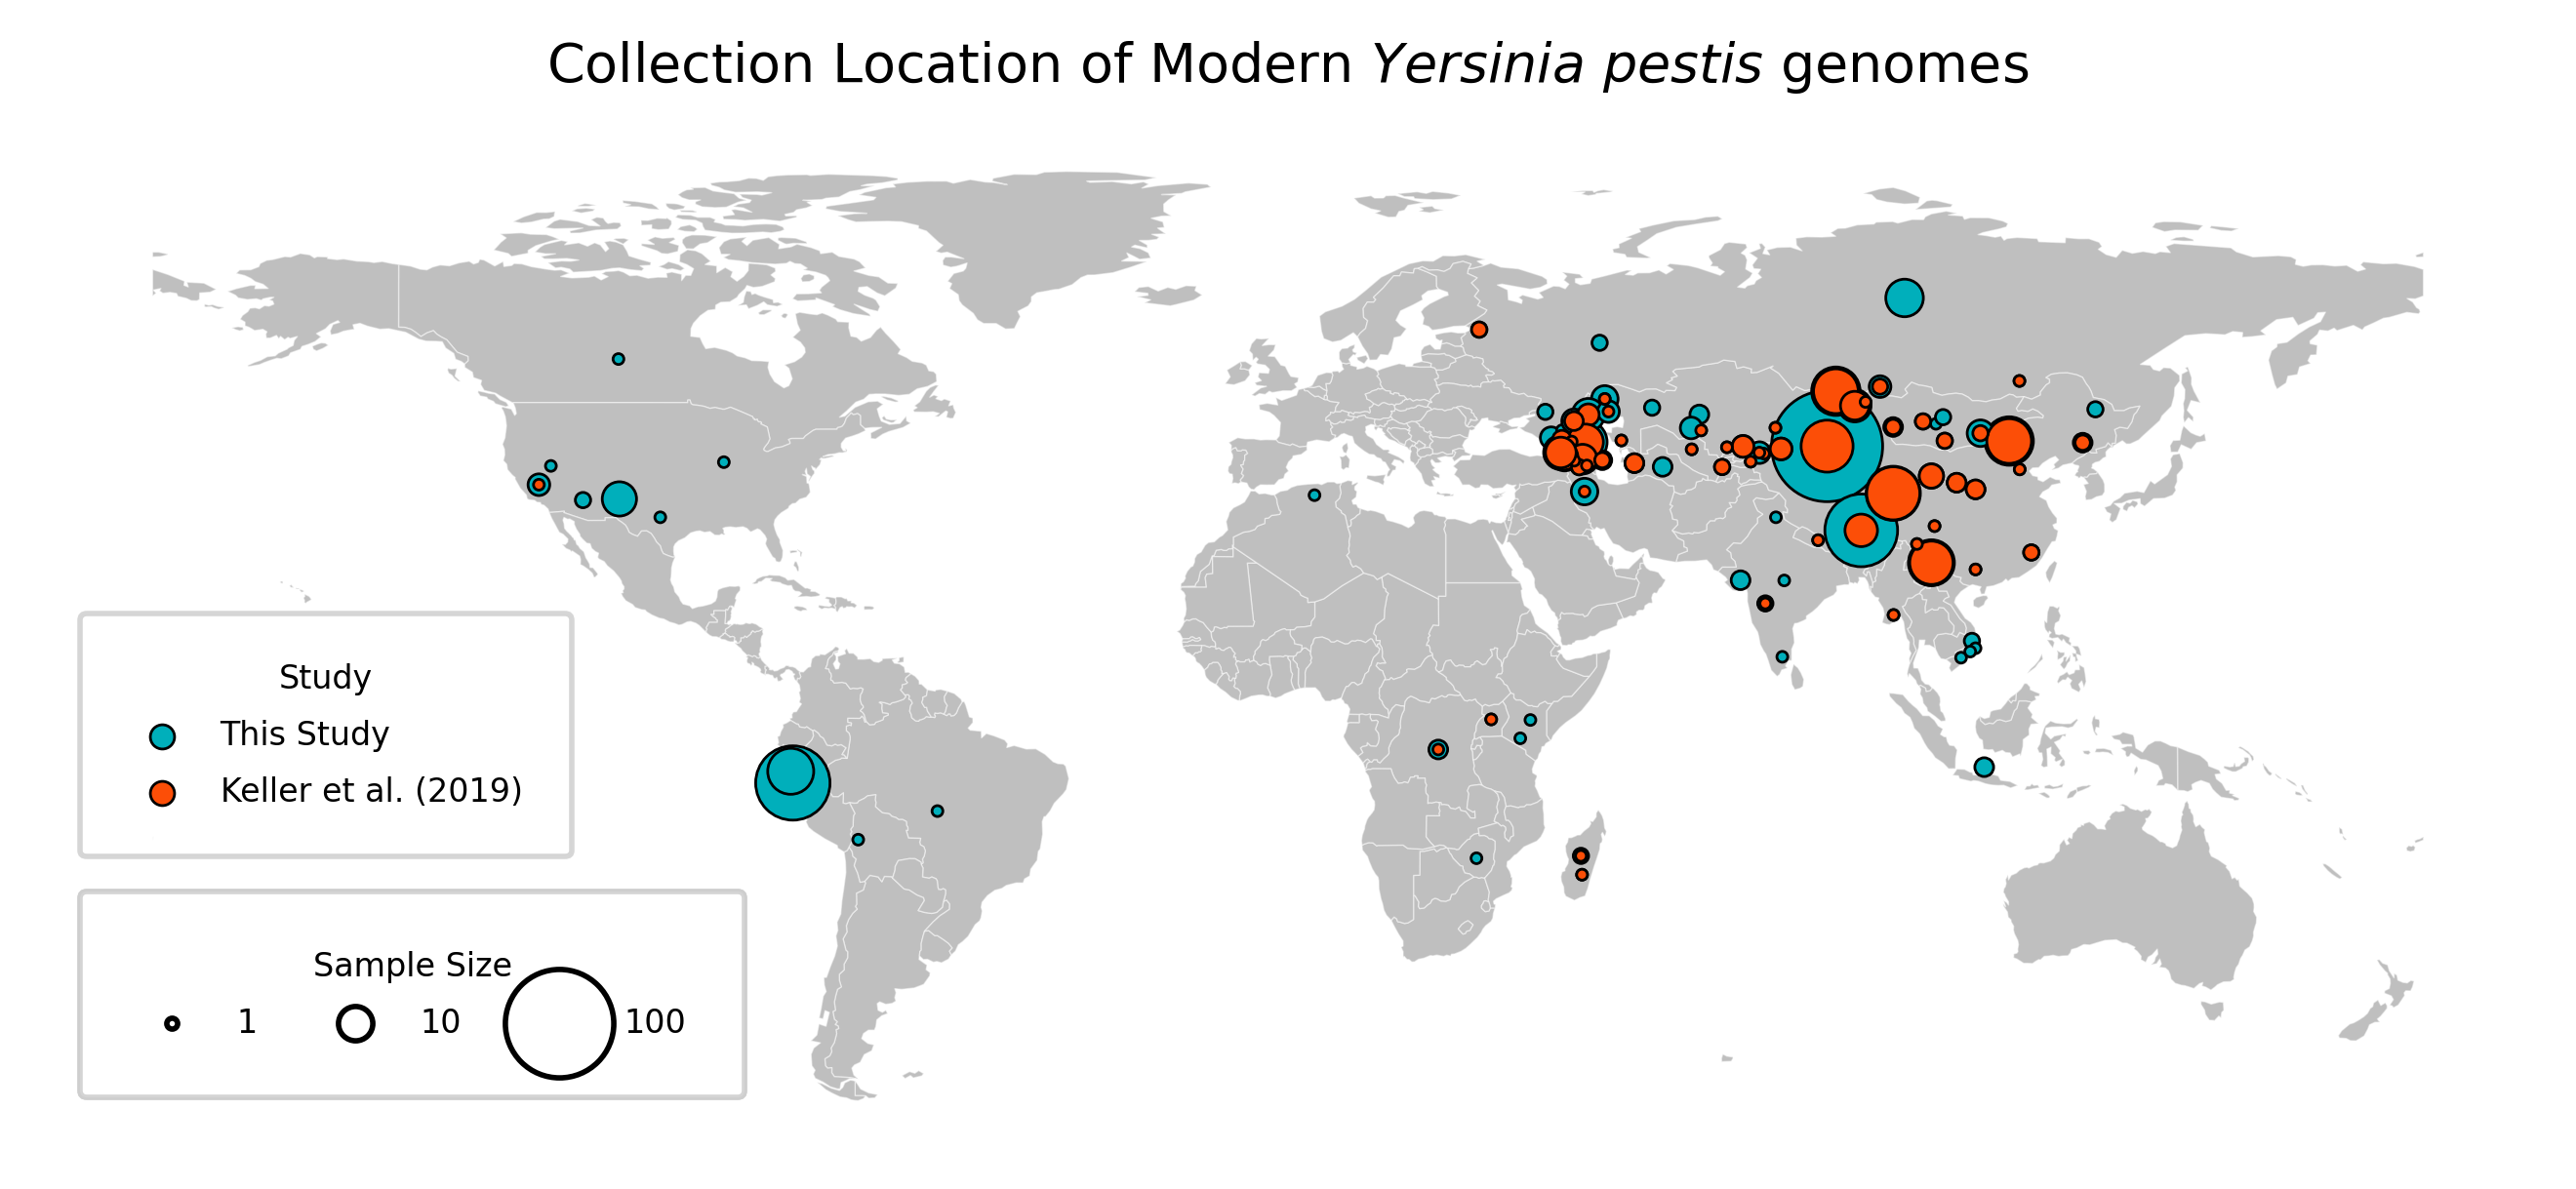

In [24]:
fig = plt.figure(figsize=figsize, dpi=dpi)
ax1 = fig.add_axes([0, 0, 1, 1])


marker_scale = 4

# --------------------------------------
# World Basemap
world_polygons.plot(ax=ax1, 
                    zorder=1, 
                    alpha=0.5, 
                    color="grey",
                    edgecolor="white", 
                    linewidth=0.25,
                   )

# This Study Data
geo_size = plot_dict["This Study"]["geo_size"]
gdf = plot_dict["This Study"]["gdf"]
gdf.plot(ax=ax1, 
         zorder=2, 
         markersize=[s*marker_scale for s in geo_size],
         color=DISC_CMAPLIST[1],
         edgecolor="black",
         linewidths=0.5,
         label=plot_dict["This Study"]["label"],
         legend=True,
         alpha=1,
         )

# Keller's Data
geo_size = plot_dict["Keller et al. 2019"]["geo_size"]
gdf = plot_dict["Keller et al. 2019"]["gdf"]
gdf.plot(ax=ax1, 
         zorder=3, 
         markersize=[s*marker_scale for s in geo_size],
         color=DISC_CMAPLIST[0],
         edgecolor="black",
         linewidths=0.5,
         label=plot_dict["Keller et al. 2019"]["label"],
         legend=True,
         alpha=1,
         )


# --------------------------------------
# Limits

# Sorry Antarctica
ax1.set_ylim(-63,)

# --------------------------------------
# Labels

ax1.set_title("Collection Location of Modern " 
          + "$\it Yersinia$" 
          + " " 
          + "$\it pestis$"
          + " " 
          + "genomes")
ax1.axis('off')

# --------------------------------------
# Legend

color_legend = ax1.legend(loc="center left",
                          bbox_to_anchor=(0.01, 0.4),
                          ncol=1,
                          borderpad = 1.5, 
                          title="Study", 
                          title_fontsize=6,
                          fontsize=6, 
                          frameon=True,
                         )
for handle in color_legend.legendHandles:
    handle.set_sizes([20])


size_l1  = plt.scatter([],[], s=1 * marker_scale, edgecolors='black', color="white")
size_l10 = plt.scatter([],[], s=10 * marker_scale, edgecolors='black', color="white")
size_l100 = plt.scatter([],[], s=100 * marker_scale, edgecolors='black', color="white")

size_labels = ["1", "10", "100"]

size_legend = plt.legend([size_l1, size_l10, size_l100], 
                 size_labels,
                 loc="center left",
                 bbox_to_anchor=(0.01, 0.15),
                 ncol=3,
                 borderpad = 1.8, 
                 title="Sample Size", 
                 title_fontsize=6,
                 fontsize=6, 
                 frameon=True,
                 #labelspacing=2,
                 handletextpad=1,
                )

ax1.add_artist(color_legend)
ax1.add_artist(size_legend)

# --------------------------------------------
# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_map." + FMT)
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

## Timeline

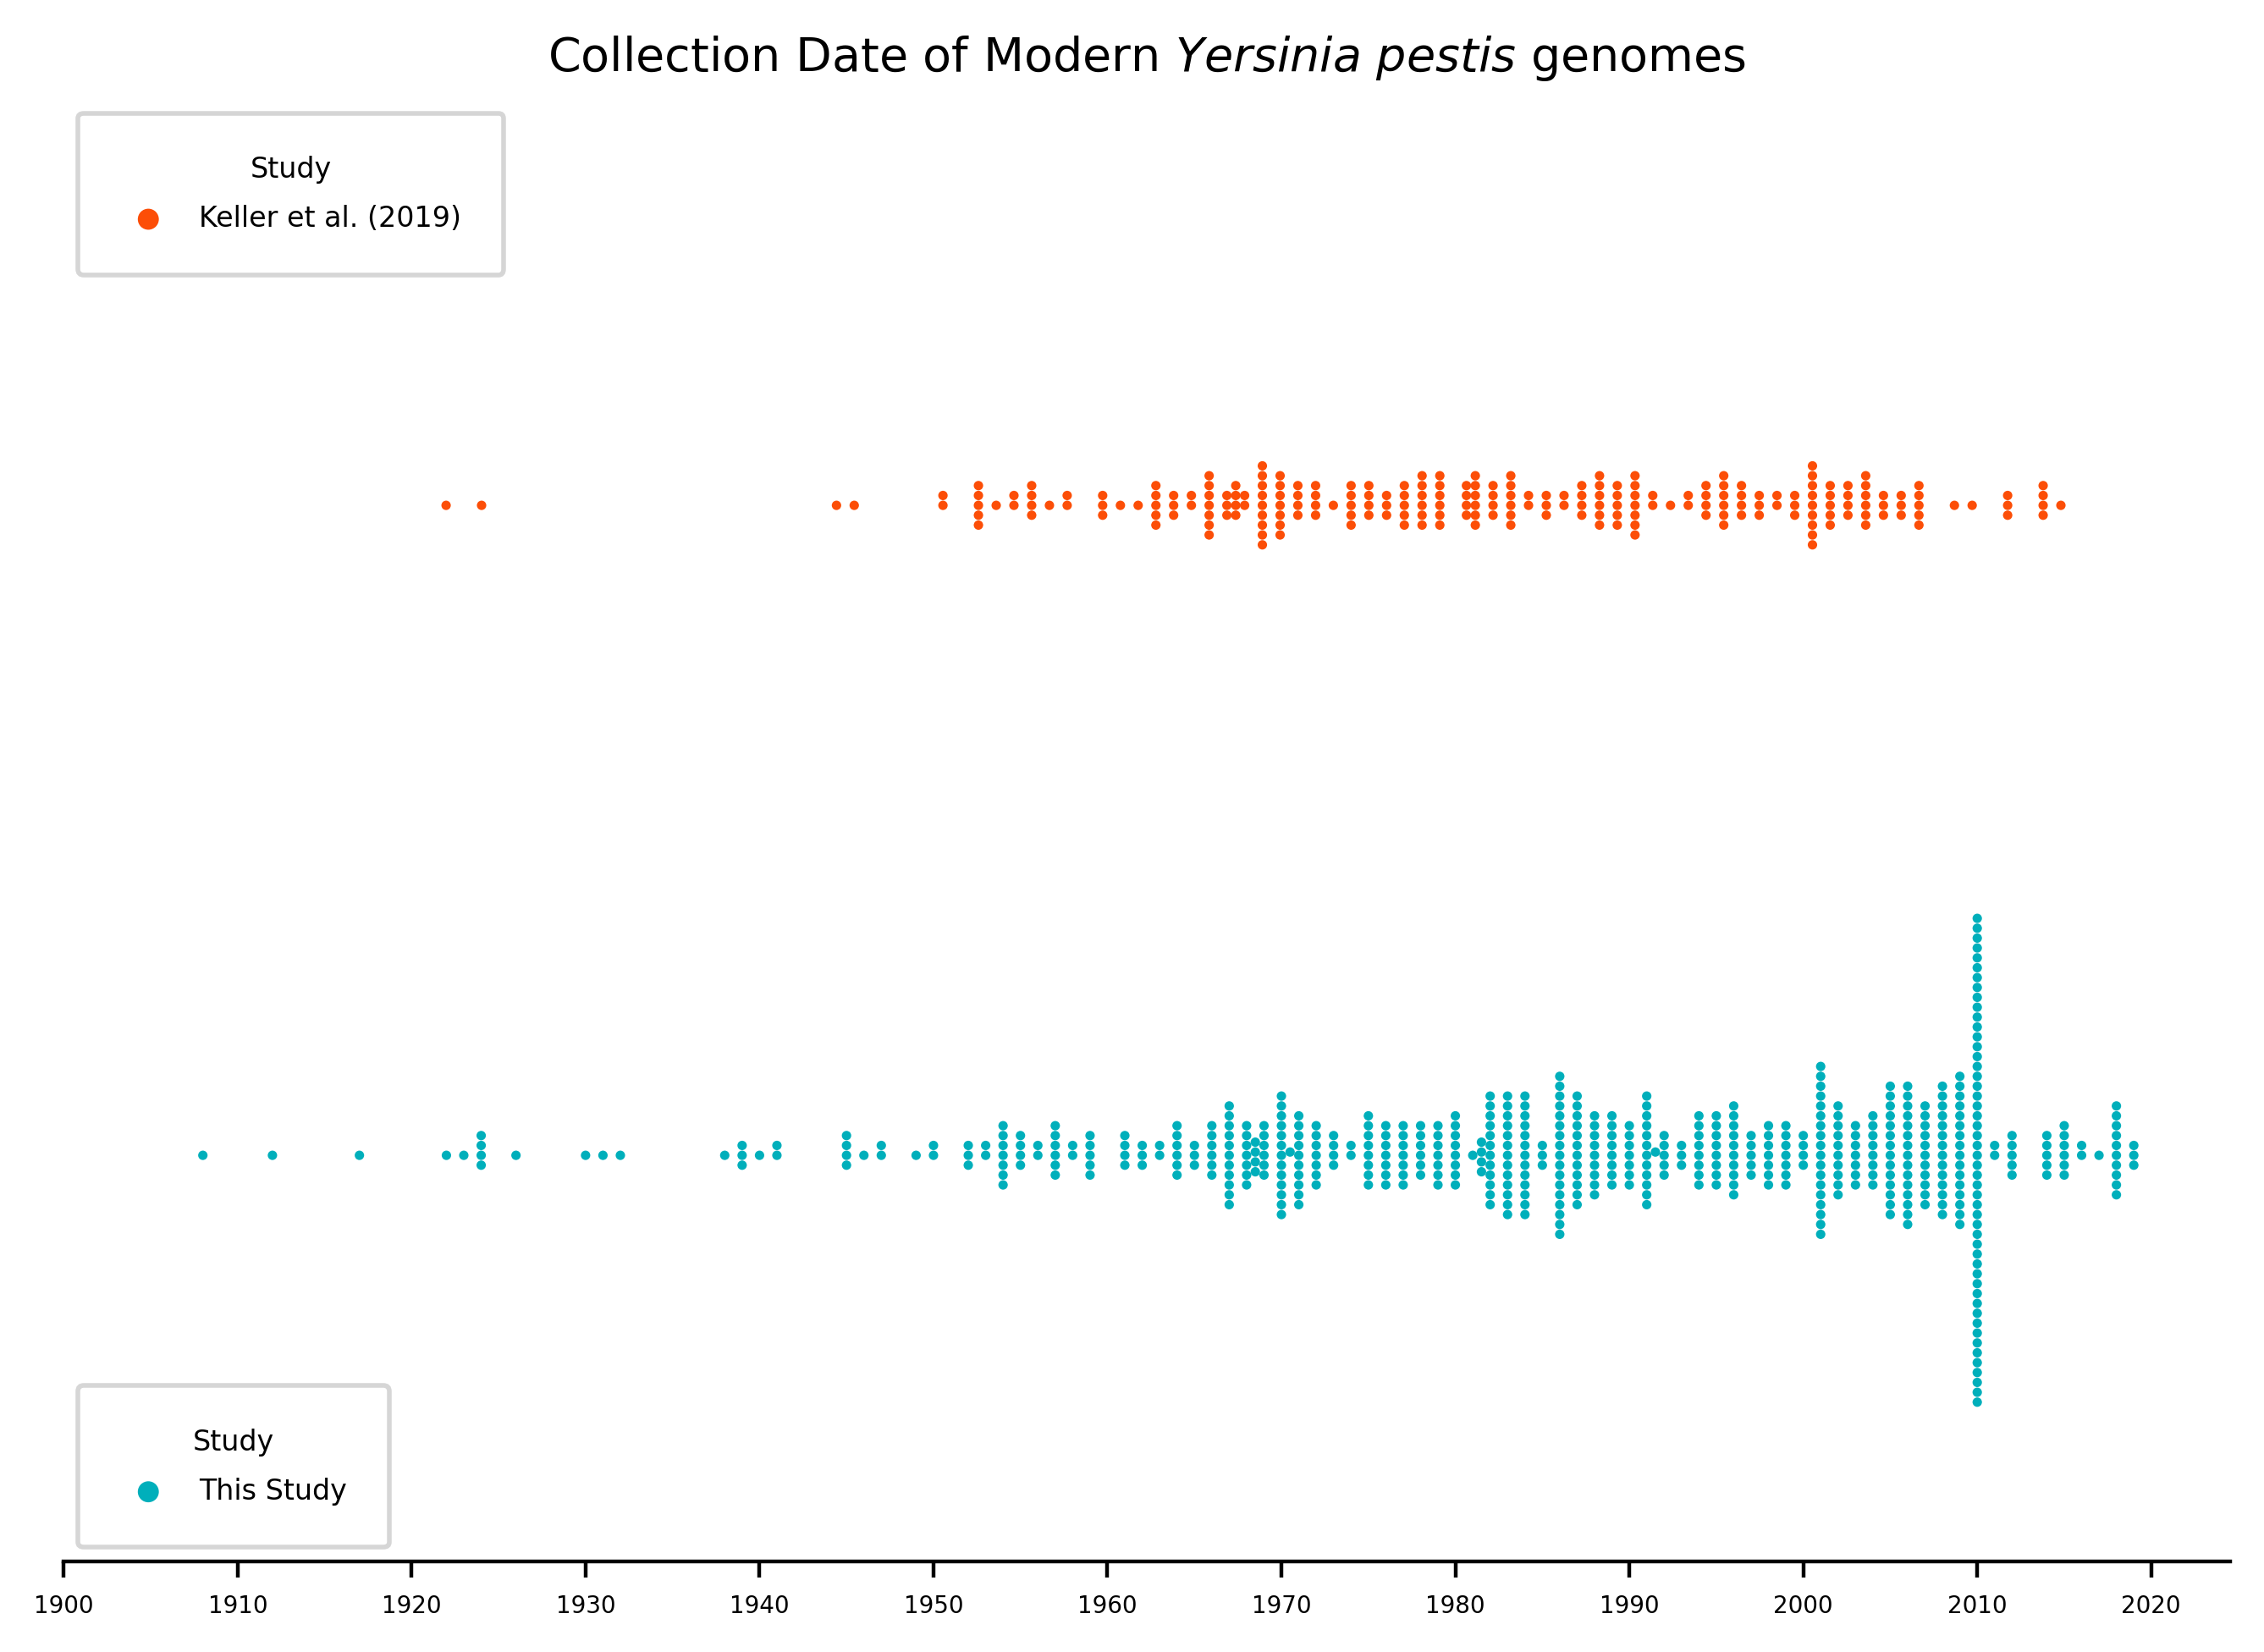

In [40]:
fig = plt.figure(figsize=figsize, dpi=dpi)
ax1 = fig.add_axes([0, 0.5, 1, 0.5])
ax2 = fig.add_axes([0, 0.1, 1, 0.5], sharex=ax1)


#marker_scale = 4

# Plot timeline
sns.swarmplot(x=plot_dict["Keller et al. 2019"]["date_list"], 
              ax=ax1, 
              size=2, 
              color=DISC_CMAPLIST[0], 
              label=plot_dict["Keller et al. 2019"]["label"])
sns.swarmplot(x=plot_dict["This Study"]["date_list"], 
              ax=ax2, 
              size=2, 
              color=DISC_CMAPLIST[1],
              label=plot_dict["This Study"]["label"])

ax1.axis("off")
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.spines['left'].set_visible(False)

ax2.set_xticks([x for x in range(1900,2021,10)])
ax2.set_yticks([])

ax1.set_title("Collection Date of Modern " 
          + "$\it Yersinia$" 
          + " " 
          + "$\it pestis$"
          + " " 
          + "genomes")

color_legend = ax1.legend(loc="upper left",
                          #bbox_to_anchor=(0, 0),
                          ncol=1,
                          borderpad = 1.5, 
                          title="Study", 
                          title_fontsize=6,
                          fontsize=6, 
                          frameon=True,
                         )
for handle in color_legend.legendHandles:
    handle.set_sizes([20])
    
color_legend = ax2.legend(loc="lower left",
                          #bbox_to_anchor=(0, 0),
                          ncol=1,
                          borderpad = 1.5, 
                          title="Study", 
                          title_fontsize=6,
                          fontsize=6, 
                          frameon=True,
                         )
for handle in color_legend.legendHandles:
    handle.set_sizes([20])

# --------------------------------------------
# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_timeline." + FMT)
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

## Tree

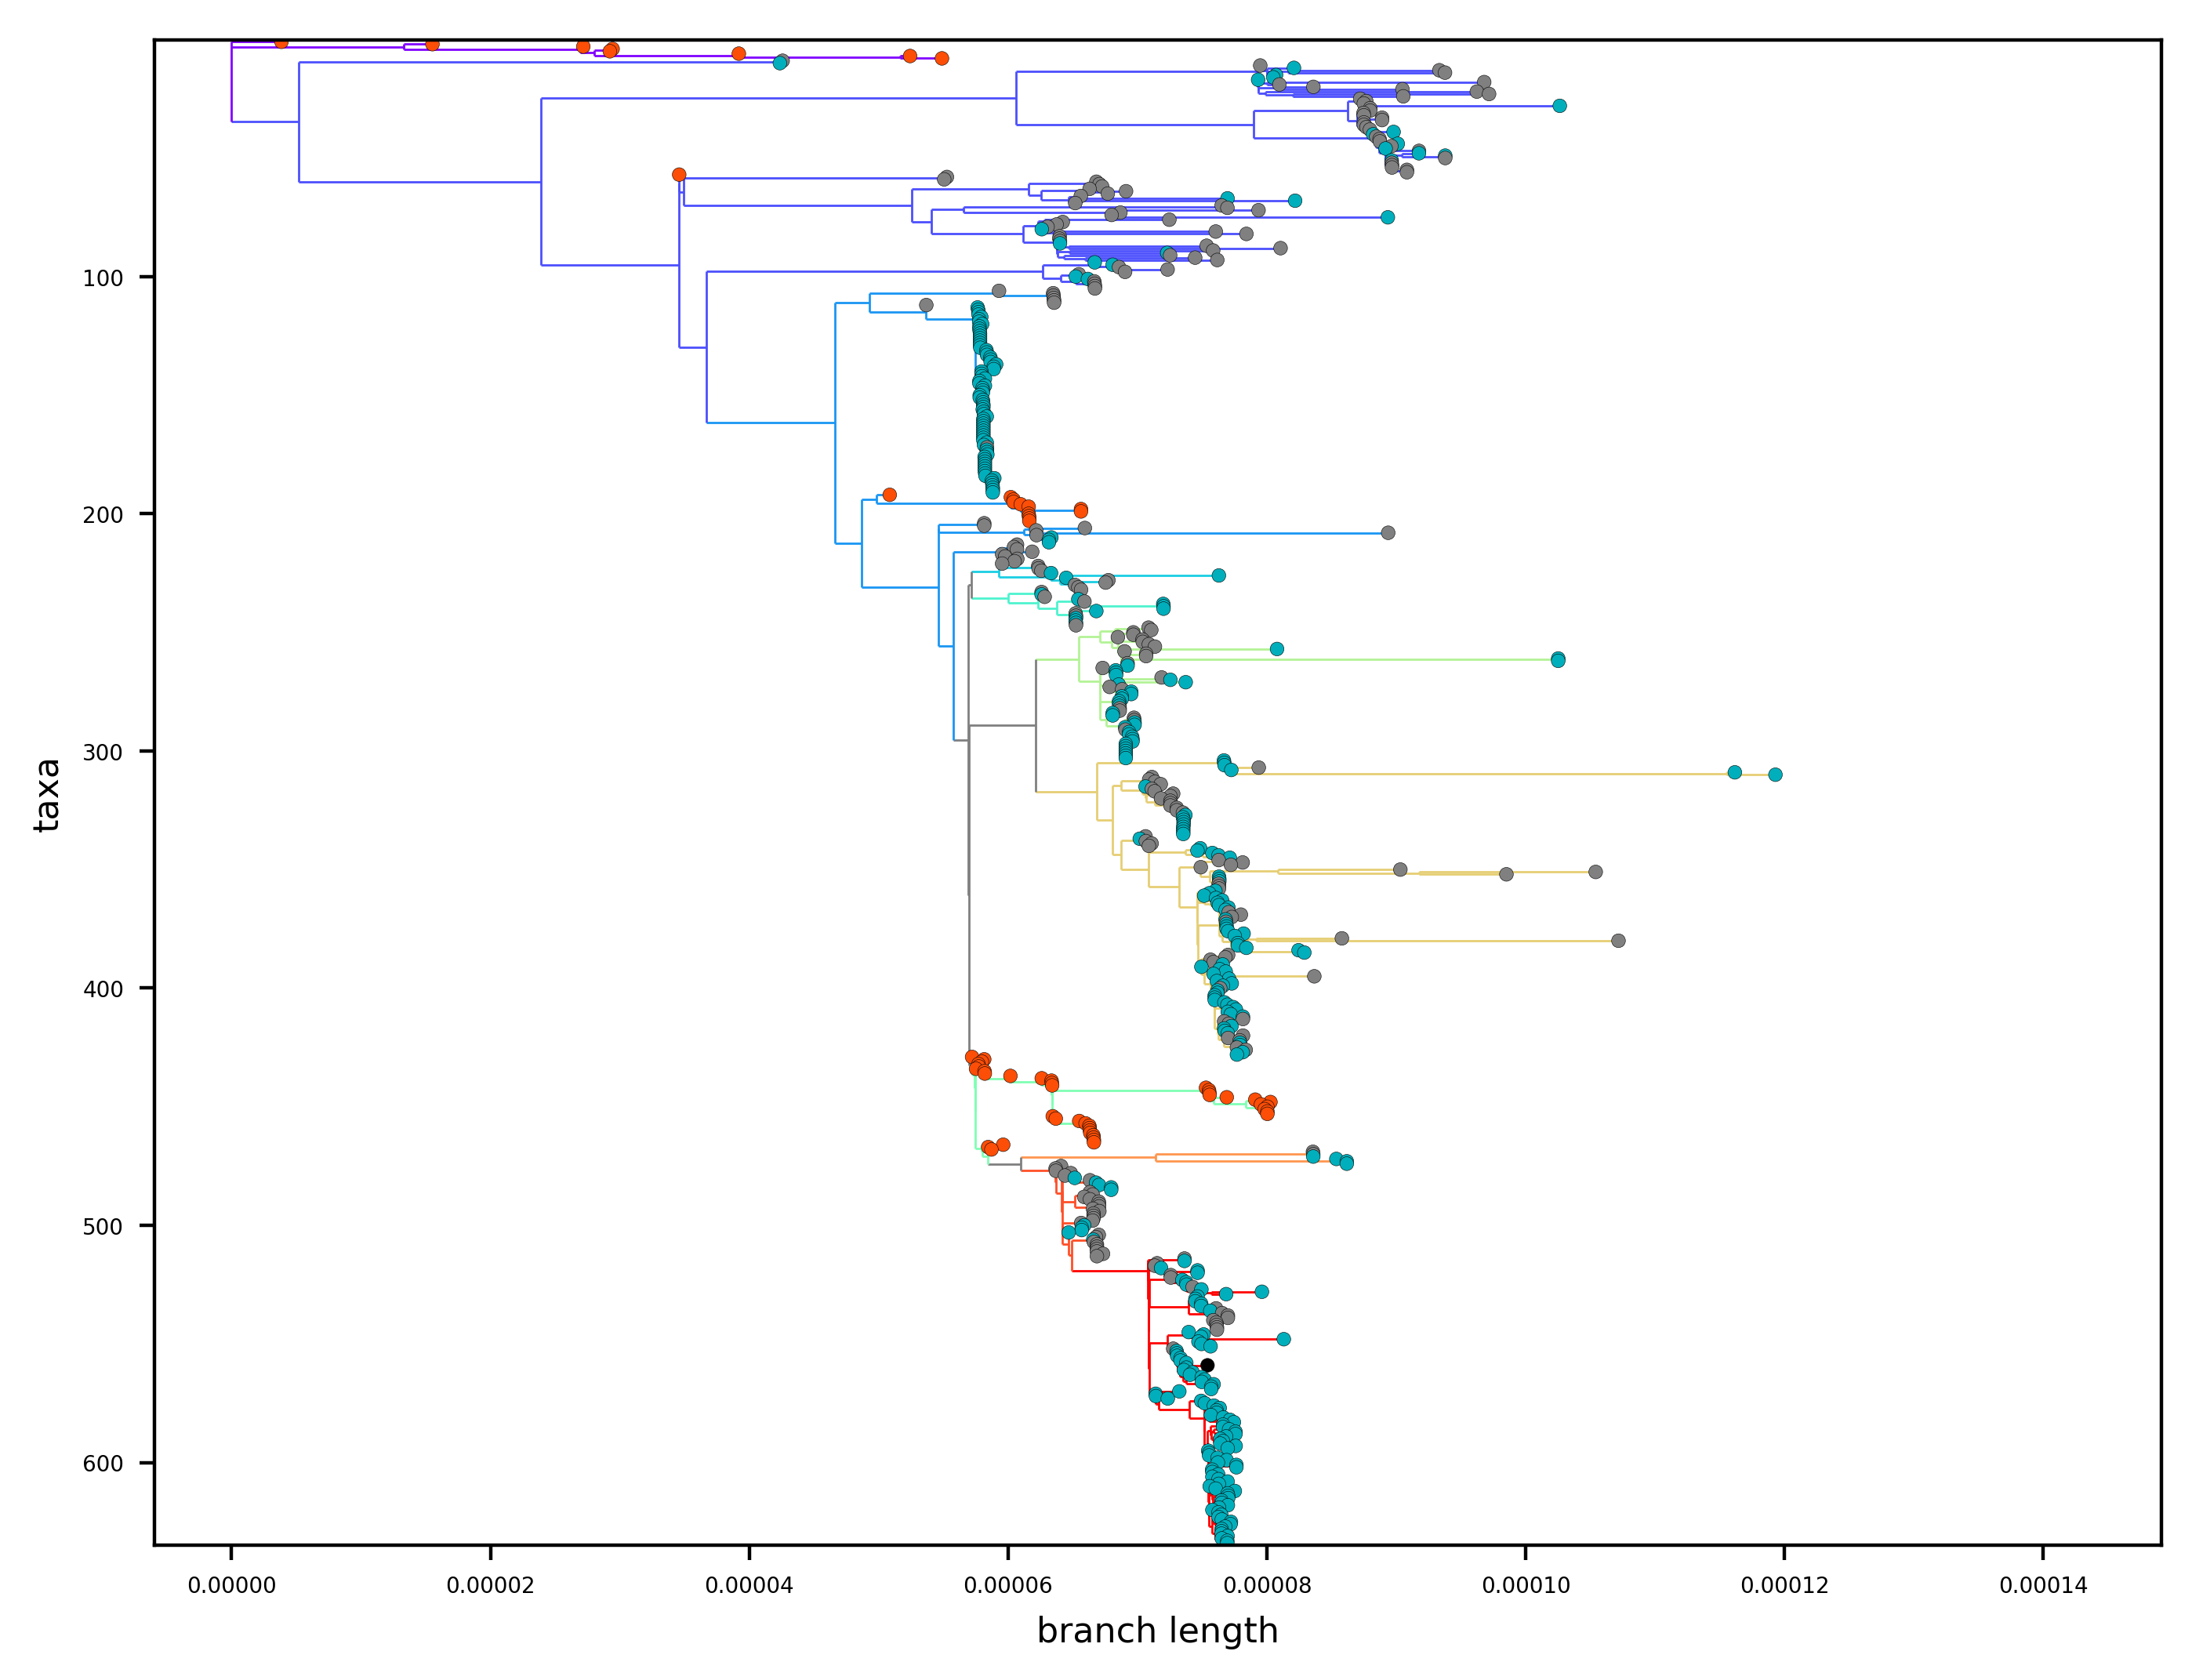

In [20]:
fig = plt.figure(figsize=figsize, dpi=dpi)
ax1 = fig.add_axes([0, 0, 1, 1])

attr = "Branch_Major"
hex_dict = color_tree(tree=tree, 
                      df=tree_df, 
                      attribute="Mugration_" + attr,
                      attribute_confidence="Mugration_" + attr + "_Confidence",
                      threshold_confidence=MUG_CONF_THRESH,                          
                      color_pal=CONT_COLOR_PAL)
    
# Plot tree     
Phylo.draw(tree,
           axes=ax1,
           show_confidence=False, 
           label_func = lambda x:'', 
           do_show=False,
          )


tip_data = tree_df[(tree_df["Branch_Support_Color"] == TERM_COL)]
ax1.scatter(data=tip_data, 
            x="coord_x", 
            y="coord_y", 
            s=10, 
            c="Study_Color", 
            edgecolor="black", 
            linewidth=0.1, 
            zorder=2)